In [7]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import json
from torch.utils.data import DataLoader
import os
from torchvision.utils import save_image

In [8]:
pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1')

mean_norms = np.array([0.485, 0.456, 0.406])
std_norms = np.array([0.229, 0.224, 0.225])

plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])

In [9]:
def load_label_map(json_file):
    """
    Load the label map from a JSON file. The files contains strings with the format "index: class_name".

    Args:
        json_file (str): Path to the JSON file containing the label map.

    Returns:
        dict: A dictionary mapping class indices to class names.
    
    """
    with open(json_file) as f:
        label_map = json.load(f)
    index_to_classname = {}
    print(index_to_classname)
    for entry in label_map:
        index_str, class_name = entry.split(': ', 1)
        index = int(index_str.strip())
        class_name = class_name.strip()
        index_to_classname[index] = class_name
    return index_to_classname

In [10]:
def evaluate(model, loader, device, image_idx):
    """
    Evaluate the accuracy of the model in predicting the top 1 and
    top 5 most likely labels for images.

    Evaluation is restricted to the 100 classes present in the dataset 
    provided by the dataloader. This may result in higher accuracy 
    compared to evaluating on all 1000 classes.

    Args:
        model (torch.nn.Module): The classifier model to evaluate.
        loader (torch.utils.data.DataLoader): Dataloader providing images and labels.
        device (torch.device): Device to run the evaluation on (e.g., 'cuda' or 'cpu').
        image_idx (dict): Mapping of image index to class index.

    Returns:
        acc1 (float): Top-1 accuracy (percentage of correctly classified images).
        acc5 (float): Top-5 accuracy (percentage of images where the correct label is within the top 5 predictions).
    """
    top1_result = 0
    top5_result = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            mapped_labels = torch.tensor([image_idx[int(l)] for l in labels]).to(device)

            #Output is 1000 logits representing the confidence score for each of the 1000 classes
            outputs = model(images)

            #Only keeping the confidence scores for the 100 included classes in the given folder
            outputs_reduced = outputs[:, 401:501]

            #Finds the top1 and top5 most confident index predictions
            _, top1 = outputs_reduced.topk(1, dim=1)
            _, top5 = outputs_reduced.topk(5, dim=1)

            #Connect indices to the fact that we're using images 401-500
            top1_preds = top1 + 401
            top5_preds = top5 + 401

            top1_result += (top1_preds.squeeze() == mapped_labels).sum().item()

            for i in range(mapped_labels.size(0)):
                if mapped_labels[i] in top5_preds[i]:
                    top5_result += 1

            total += mapped_labels.size(0)

    acc1 = top1_result / total * 100
    acc5 = top5_result / total * 100
    
    return acc1, acc5

In [11]:
def print_eval(title, acc1, acc5, baseline_acc1, baseline_acc5):
    print(f"[{title}] Top-1: {acc1:.2f}% | Top-5: {acc5:.2f}%")
    print(f"Compare: Top-1 Drop {baseline_acc1 - acc1:.2f}%")
    print(f"Top-5 Drop {baseline_acc5 - acc5:.2f}%")

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pretrained_model.to(device)
pretrained_model.eval()
criterion = torch.nn.CrossEntropyLoss()

In [13]:
dataset_path = "/kaggle/input/testdataset/TestDataSet"
json_path = os.path.join(dataset_path, "labels_list.json")
index_to_classname = load_label_map(json_path)
image_idx = {i: int(index) for i, index in enumerate(index_to_classname.keys())}

dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=plain_transforms)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

{}


Find the maximum and minimum pixel values across the entire dataset.

These values will be used for clipping pixel values during adversarial image generation (Tasks 3-5) to ensure that the generated 
adversarial images remain within a valid range.

Clipping is crucial to maintain image integrity and prevent generating invalid pixel values.


In [14]:
import torch

global_max = float('-inf')
global_min = float('inf')

for images, _ in dataloader:
    batch_max = images.max().item()
    batch_min = images.min().item()
    
    if batch_max > global_max:
        global_max = batch_max
    if batch_min < global_min:
        global_min = batch_min
# this value will be used for the clip for task 3-4-5
print(f"Maximum pixel value across dataset: {global_max}")
print(f"Minimum pixel value across dataset: {global_min}")

Maximum pixel value across dataset: 2.640000104904175
Minimum pixel value across dataset: -2.1179039478302


This code defines a transformation to reverse the normalization applied to images. 

This is necessary for displaying or saving images, as normalization is typically used during model training but alters pixel values for optimal performance. 

By inverting the normalization, we can restore the original pixel values for visualization.

In [15]:
inv_normalize = transforms.Normalize(
    mean=[-m/s for m,s in zip(mean_norms, std_norms)],
    std=[1/s for s in std_norms]
)

## Generating Adversarial Image

In [16]:
def generate_adversarial(model, loader, device, epsilon, save_dir, image_idx, mean_norms, std_norms):
    """
    Generate adversarial images using the FGSM (Fast Gradient Sign Method) attack.

    The attack perturbs the input images by adding a small amount of noise, 
    controlled by the `epsilon` parameter, in the direction of the gradient 
    of the loss function. This pushes the image towards a region where 
    the model is more likely to misclassify it.

    Clips the generated images to ensure they remain within
    the range of normalized pixel values observed in the dataset and
    saves them to the specified directory.
    """

    for idx, (images, labels) in enumerate(loader):
        images = images.to(device)
        # since the model at evaluating (default is "false")
        images.requires_grad = True

        mapped_labels = torch.tensor([image_idx[int(l)] for l in labels]).to(device)

        outputs = model(images)
        loss = criterion(outputs, mapped_labels)

        model.zero_grad()
        loss.backward()

        # (∇xL)
        data_grad = images.grad.data
        
        # x<-x+ϵ⋅sign(∇xL)
        adv_images = images + epsilon * data_grad.sign()

        # Clip the pixel values of the adversarial images to ensure they remain 
        # within the range of normalized pixel values observed in the dataset. 
        # This prevents generating invalid or out-of-distribution pixel values.
        adv_images = torch.clamp(adv_images, global_min, global_max)

        for i in range(adv_images.size(0)):
            class_idx = labels[i].item()  # original class index from ImageFolder
            class_dir = os.path.join(save_dir, str(class_idx))
            os.makedirs(class_dir, exist_ok=True)

            img_inv = inv_normalize(adv_images[i].cpu())
            save_path = os.path.join(class_dir, f"adv_{idx * loader.batch_size + i:03d}.png")
            save_image(img_inv, save_path)

## Generating Projected Gradient Descent Adversarial

Using Projected Gradient Descent (PGD) to create stronger adversarial examples:

PGD works like Gradient Descent:
→ Each step adds a small perturbation (controlled by a step size alpha, similar to a learning rate).

Unlike FGSM (which takes one large step), PGD takes multiple smaller steps toward the adversarial direction.

At every step:

Compute the gradient with respect to adv_images.

Move a small step (alpha) in the direction of the gradient sign (like FGSM but smaller step).

Clip the perturbation to make sure the total change stays within the allowed epsilon budget → i.e., it doesn’t exceed ± epsilon distance from the original image.

After multiple iterations:

The perturbations accumulate, gradually making the image more adversarial.

This iterative process allows PGD to find stronger adversarial examples that are harder for the model to classify correctly.

Compared to FGSM, PGD is harder to defend against because it repeatedly “refines” the attack instead of attacking in a single step.

In [17]:
def generate_pgd_adversarial(model, loader, device, epsilon, alpha, num_iter, save_dir, image_idx, mean_norms, std_norms):
    """
    Generate adversarial images using the Projected Gradient Descent (PGD) attack.

    See description above.

    Clips the generated images to ensure they remain within
    the range of normalized pixel values observed in the dataset and
    saves them to the specified directory.
    """
    for idx, (images, labels) in enumerate(loader):
        images = images.to(device)
        ori_images = images.clone().detach()
        images.requires_grad = True

        mapped_labels = torch.tensor([image_idx[int(l)] for l in labels]).to(device)
        # store original image, no gradient, since we going to modify the value of image
        # it is better to detach it (which means make a new copy, and manipulate it,
        # so it will not affect the original image)
        adv_images = images.clone().detach()

        for _ in range(num_iter):
            adv_images.requires_grad = True
            outputs = model(adv_images)
            loss = criterion(outputs, mapped_labels)

            model.zero_grad()
            loss.backward()
            
            # x adv=x+α⋅sign(∇xL)
            grad = adv_images.grad.data
            adv_images = adv_images + alpha * grad.sign()
            
            # limit the value of pertubulation within in the range of ori_images + epsilon and ori_images - epsilon
            adv_images = torch.max(torch.min(adv_images, ori_images + epsilon), ori_images - epsilon)

            # Clip the pixel values to ensure they remain within the range of normalized pixel values.
            adv_images = torch.clamp(adv_images, global_min, global_max).detach()

        for i in range(adv_images.size(0)):
            class_idx = labels[i].item()
            class_dir = os.path.join(save_dir, str(class_idx))
            os.makedirs(class_dir, exist_ok=True)
            img_inv = inv_normalize(adv_images[i].cpu())
            save_path = os.path.join(class_dir, f"adv_pgd_{idx * loader.batch_size + i:03d}.png")
            save_image(img_inv, save_path)

# Generating Patch PGD Adversarial (non-target and target)

hypothesis : the location of the patch may affect a lot: good approach: fix location, edge, center. But the question ask for the random. May put it in the future work for research

In [37]:
def generate_pgd_patch_adversarial(model, loader, device, epsilon, alpha, num_iter, save_dir, image_idx, mean_norms, std_norms, patch_size=32):
    for idx, (images, labels) in enumerate(loader):
        images = images.to(device)
        ori_images = images.clone().detach()
        adv_images = images.clone().detach()

        H, W = images.shape[2], images.shape[3]
        x = np.random.randint(0, H - patch_size + 1)
        y = np.random.randint(0, W - patch_size + 1)

        for _ in range(num_iter):
            adv_images.requires_grad = True
            outputs = model(adv_images)
            mapped_labels = torch.tensor([image_idx[int(l)] for l in labels]).to(device)

            loss = criterion(outputs, mapped_labels)
            model.zero_grad()
            loss.backward()

            grad = adv_images.grad.data

            # Only update the patch area
            grad_patch = grad[:, :, x:x+patch_size, y:y+patch_size]
            adv_patch = adv_images[:, :, x:x+patch_size, y:y+patch_size]

            adv_patch = adv_patch + alpha * grad_patch.sign()
            adv_patch = torch.max(torch.min(
            adv_patch,
            ori_images[:, :, x:x+patch_size, y:y+patch_size] + epsilon),
            ori_images[:, :, x:x+patch_size, y:y+patch_size] - epsilon
            )
            adv_patch = torch.clamp(adv_patch, global_min, global_max)

            # ✅ detach adv_images from auto grad
            adv_images = adv_images.detach()
            adv_images[:, :, x:x+patch_size, y:y+patch_size] = adv_patch.detach()

        for i in range(adv_images.size(0)):
            class_idx = labels[i].item()
            class_dir = os.path.join(save_dir, str(class_idx))
            os.makedirs(class_dir, exist_ok=True)

            img_inv = inv_normalize(adv_images[i].cpu())
            save_path = os.path.join(class_dir, f"adv_patch_{idx * loader.batch_size + i:03d}.png")
            save_image(img_inv, save_path)

In [19]:
def generate_pgd_patch_targeted_adversarial(
    model, loader, device, epsilon, alpha, num_iter, save_dir,
    image_idx, mean_norms, std_norms, patch_size=32, target_class=401
):
    for idx, (images, labels) in enumerate(loader):
        images = images.to(device)
        ori_images = images.clone().detach()
        adv_images = images.clone().detach()

        H, W = images.shape[2], images.shape[3]
        x = np.random.randint(0, H - patch_size + 1)
        y = np.random.randint(0, W - patch_size + 1)

        # Set all targets to the desired class
        target_labels = torch.full((images.size(0),), target_class, dtype=torch.long).to(device)

        for _ in range(num_iter):
            adv_images.requires_grad = True
            outputs = model(adv_images)

            # Use target labels to guide attack towards target class
            loss = criterion(outputs, target_labels)

            model.zero_grad()
            loss.backward()

            grad = adv_images.grad.data

            grad_patch = grad[:, :, x:x + patch_size, y:y + patch_size]
            adv_patch = adv_images[:, :, x:x + patch_size, y:y + patch_size]

            # Targeted attack uses NEGATIVE gradient direction
            adv_patch = adv_patch - alpha * grad_patch.sign()

            adv_patch = torch.max(
                torch.min(adv_patch, ori_images[:, :, x:x + patch_size, y:y + patch_size] + epsilon),
                ori_images[:, :, x:x + patch_size, y:y + patch_size] - epsilon
            )
            adv_patch = torch.clamp(adv_patch, 0, 1)

            adv_images = adv_images.detach()
            adv_images[:, :, x:x + patch_size, y:y + patch_size] = adv_patch.detach()


        for i in range(adv_images.size(0)):
            class_idx = labels[i].item()
            class_dir = os.path.join(save_dir, str(class_idx))
            os.makedirs(class_dir, exist_ok=True)

            img_inv = inv_normalize(adv_images[i].cpu())
            save_path = os.path.join(class_dir, f"adv_pgd_targeted_{idx * loader.batch_size + i:03d}.png")
            save_image(img_inv, save_path)


## Result for Task 1~4

In [43]:
# Task 2: Adversarial
# Generate adversarial image
adversarial_test_save_dir = "./Adversarial_Test_Set_1"
adv_epsilon = 0.02
generate_adversarial(
    model=pretrained_model,
    loader=dataloader,
    device=device,
    epsilon=adv_epsilon,
    save_dir=adversarial_test_save_dir,
    image_idx=image_idx,
    mean_norms=mean_norms,
    std_norms=std_norms
)
adv_dataset = torchvision.datasets.ImageFolder(root=adversarial_test_save_dir, transform=plain_transforms)
adv_loader = DataLoader(adv_dataset, batch_size=32, shuffle=False)

In [47]:
# Task 3: pgd adversarial
# Generate pgd adversarial image
pgd_save_dir = "./Adversarial_Test_Set_2"
pgd_epsilon = 0.02
pgd_alpha = 0.005
pgd_num_iter = 10
generate_pgd_adversarial(
    model=pretrained_model,
    loader=dataloader,
    device=device,
    epsilon=pgd_epsilon,
    alpha=pgd_alpha,
    num_iter=pgd_num_iter,
    save_dir=pgd_save_dir,
    image_idx=image_idx,
    mean_norms=mean_norms,
    std_norms=std_norms
)

pgd_adv_dataset = torchvision.datasets.ImageFolder(root=pgd_save_dir, transform=plain_transforms)
pgd_adv_loader = DataLoader(pgd_adv_dataset, batch_size=32, shuffle=False)

In [65]:
# Task 4: patch
# Generate patch pgd adversarial image 
patch_save_dir = "./Adversarial_Test_Set_3"
patch_epsilon = 0.02
patch_alpha = 0.01
patch_num_iter = 10
generate_pgd_patch_adversarial(
    model=pretrained_model,
    loader=dataloader,
    device=device,
    epsilon=patch_epsilon,
    alpha=patch_alpha,
    num_iter=patch_num_iter,
    save_dir=patch_save_dir,
    image_idx=image_idx,
    mean_norms=mean_norms,
    std_norms=std_norms
)

patch_pgd_adv_dataset = torchvision.datasets.ImageFolder(root=patch_save_dir, transform=plain_transforms)
patch_pgd_adv_loader = DataLoader(patch_pgd_adv_dataset, batch_size=32, shuffle=False)

In [17]:
generate_pgd_patch_targeted_adversarial(
    model=pretrained_model,
    loader=dataloader,
    device=device,
    epsilon=0.3,
    alpha=0.01,
    num_iter=20,
    save_dir="./Adversarial_Targeted_Patch",
    image_idx=image_idx,
    mean_norms=mean_norms,
    std_norms=std_norms,
    patch_size=32,
    target_class=401  # 🎯 攻击目标类别
)
target_patch_pgd_adv_dataset = torchvision.datasets.ImageFolder(root="./Adversarial_Targeted_Patch", transform=plain_transforms)
target_patch_pgd_adv_loader = DataLoader(target_patch_pgd_adv_dataset, batch_size=32, shuffle=False)

In [66]:
# Evaluate original
# in this case, we are restrict to indices 401-500 instead 1000 class output
top1_acc, top5_acc = evaluate(pretrained_model, dataloader, device, image_idx)
print_eval("Original", top1_acc, top5_acc, top1_acc, top5_acc)

# adversarial
adv_top1_acc, adv_top5_acc = evaluate(pretrained_model, adv_loader, device, image_idx)
print_eval("Adversarial", adv_top1_acc, adv_top5_acc, top1_acc, top5_acc)

# pgd adversarial
pgd_adv_top1_acc, pgd_adv_top5_acc = evaluate(pretrained_model, pgd_adv_loader, device, image_idx)
print_eval("PGD Adversarial", pgd_adv_top1_acc, pgd_adv_top5_acc, top1_acc, top5_acc)

# patch pgd adversarial
patch_pgd_adv_top1_acc, patch_pgd_adv_top5_acc = evaluate(pretrained_model, patch_pgd_adv_loader, device, image_idx)
print_eval("Patch PGD Adversarial", patch_pgd_adv_top1_acc, patch_pgd_adv_top5_acc, top1_acc, top5_acc)

[Original] Top-1: 89.60% | Top-5: 99.40%
Compare: Top-1 Drop 0.00%
Top-5 Drop 0.00%
[Adversarial] Top-1: 3.00% | Top-5: 10.60%
Compare: Top-1 Drop 86.60%
Top-5 Drop 88.80%
[PGD Adversarial] Top-1: 1.00% | Top-5: 6.40%
Compare: Top-1 Drop 88.60%
Top-5 Drop 93.00%
[Patch PGD Adversarial] Top-1: 9.60% | Top-5: 14.60%
Compare: Top-1 Drop 80.00%
Top-5 Drop 84.80%


In [19]:
target_target_patch_pgd_adv_top1_acc, target_patch_pgd_adv_top5_acc = evaluate(pretrained_model, target_patch_pgd_adv_loader, device, image_idx)
print_eval("target Patch PGD Adversarial", target_target_patch_pgd_adv_top1_acc, target_patch_pgd_adv_top5_acc, top1_acc, top5_acc)

[target Patch PGD Adversarial] Top-1: 10.20% | Top-5: 14.60%
Compare: Top-1 Drop 79.40%
Top-5 Drop 84.80%


## Task 5 Using Densenet 121 model to verify the image

In [20]:
# Using DenseNet-121
new_model = torchvision.models.densenet121(weights='IMAGENET1K_V1')
new_model = new_model.to(device)
new_model.eval()

# Evaluating 
original_acc1, original_acc5 = evaluate(new_model, dataloader, device, image_idx)
adv1_acc1, adv1_acc5 = evaluate(new_model, adv_loader, device, image_idx)
adv2_acc1, adv2_acc5 = evaluate(new_model, pgd_adv_loader, device, image_idx)
adv3_acc1, adv3_acc5 = evaluate(new_model, patch_pgd_adv_loader, device, image_idx)
adv4_acc1, adv4_acc5 = evaluate(new_model, target_patch_pgd_adv_loader, device, image_idx)

print(f"Original: Top-1 {original_acc1:.2f}%, Top-5 {original_acc5:.2f}%")
print(f"FGSM:     Top-1 {adv1_acc1:.2f}%, Top-5 {adv1_acc5:.2f}%")
print(f"PGD:      Top-1 {adv2_acc1:.2f}%, Top-5 {adv2_acc5:.2f}%")
print(f"Patch:    Top-1 {adv3_acc1:.2f}%, Top-5 {adv3_acc5:.2f}%")
print(f"Target:    Top-1 {adv4_acc1:.2f}%, Top-5 {adv4_acc5:.2f}%")

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 150MB/s] 


Original: Top-1 88.00%, Top-5 98.40%
FGSM:     Top-1 10.20%, Top-5 14.40%
PGD:      Top-1 10.00%, Top-5 14.60%
Patch:    Top-1 10.00%, Top-5 15.00%
Target:    Top-1 10.40%, Top-5 15.00%


In [55]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import random

def _find_adv_path(adv_root: str, local_label: int, idx: int):
    """
    Try each prefix in turn and return the first existing path:
      adv_root/<local_label>/adv_{idx:03d}.png
      adv_root/<local_label>/adv_pgd_{idx:03d}.png
      adv_root/<local_label>/adv_patch_{idx:03d}.png
    """
    class_dir = os.path.join(adv_root, str(local_label))
    for prefix in ("adv", "adv_pgd", "adv_patch"):
        name = f"{prefix}_{idx:03d}.png"
        p = os.path.join(class_dir, name)
        if os.path.exists(p):
            return p
    return None

def visualize_adversarial(
    dataset,             # torchvision.datasets.ImageFolder of originals
    adv_root,            # root of saved adversarial folders
    model,               # pretrained model (.eval())
    plain_transforms,    # ToTensor+Normalize you used
    image_idx,           # {local_label->ImageNet idx}
    index_to_classname,  # {ImageNet idx->human name}
    epsilon=0.02,
    num_examples=5
):
    """
    Verifies L∞ ≤ epsilon, then shows up to num_examples randomly sampled flips,
    restricting predictions to only the 401–500 classes.
    """
    device = next(model.parameters()).device

    # 1) Check L∞ bound
    violated = False
    for idx, (orig_path, local) in enumerate(dataset.imgs):
        adv_path = _find_adv_path(adv_root, local, idx)
        if adv_path is None:
            raise FileNotFoundError(f"No adversarial image for idx={idx}, class={local}")
        o = np.array(Image.open(orig_path).convert('RGB'))/255.0
        a = np.array(Image.open(adv_path).convert('RGB'))/255.0
        print(np.max(np.abs(a - o)))
        if np.max(np.abs(a - o)) > epsilon + 1e-6:
            print(f"L∞ violation at idx={idx}: {np.max(np.abs(a - o)):.4f}")
            violated = True
            break
    print(f"L∞ ≤ {epsilon}? {'NO' if violated else 'YES'}")

    # 2) Collect *all* flips 
    # (model predicted correctly on oringal image but incorrectly on adversarial image)
    all_picks = []
    model.eval()
    for idx, (orig_path, local) in enumerate(dataset.imgs):
        true_idx = image_idx[local]  # e.g. 401–500

        # Original prediction over restricted classes 401-500
        # Only keeps images where the model predicted correctly
        x0 = plain_transforms(Image.open(orig_path).convert('RGB'))\
                 .unsqueeze(0).to(device)
        with torch.no_grad():
            logits0 = model(x0)[:, 401:501]
            p0_rel  = logits0.argmax(1).item()
            p0      = p0_rel + 401
        if p0 != true_idx:
            continue

        # Adversarial prediction over restricted classes 401-500
        # Only keeps adversarial images where the mode predicted incorrectly
        adv_path = _find_adv_path(adv_root, local, idx)
        x1 = plain_transforms(Image.open(adv_path).convert('RGB'))\
                 .unsqueeze(0).to(device)
        with torch.no_grad():
            logits1 = model(x1)[:, 401:501]

            #Get the top 5 for the visualization
            _, rel_top5 = logits1.topk(5, dim=1)
            top5_rel  = rel_top5[0].cpu().numpy().astype(int)
            top5      = top5_rel + 401

            #Get the models prediction on the adversarial image
            p1_rel    = logits1.argmax(1).item()
            p1        = p1_rel + 401

            # Get probability distribution over the 100 labels
            # Used to give probabilities for the top 5 in visualization
            probs100  = F.softmax(logits1[0], dim=0).cpu().numpy()

        if p1 == true_idx:
            continue

        # prepare plotting data
        o = np.array(Image.open(orig_path).convert('RGB'))/255.0
        a = np.array(Image.open(adv_path).convert('RGB'))/255.0
        noise = np.clip((a - o)/epsilon/2 + 0.5, 0, 1)

        # The correct label for the picture
        true_name = index_to_classname[true_idx]

        # The models predicted label on the adversarial image
        pred_name = index_to_classname[p1]

        # Top 5 predicted labels on the adversarial image
        top5_names = [index_to_classname[i] for i in top5]

        # Percentage of confidence for the top 5 labels on the adversarial image
        top5_confs = probs100[top5_rel]

        all_picks.append((o, a, noise, true_name, pred_name, top5_names, top5_confs))

    if not all_picks:
        print("No flipped examples found.")
        return

    # 3) Randomly sample and plot
    picks = random.sample(all_picks, min(len(all_picks), num_examples))
    n = len(picks)
    fig, axes = plt.subplots(n, 4, figsize=(16, 4*n))
    if n == 1:
        axes = axes[np.newaxis, :]

    for i, (o, a, noise, tname, pname, names5, confs5) in enumerate(picks):
        ax0, ax1, ax2, ax3 = axes[i]
        ax0.imshow(o)
        ax0.set_title(f"Original\n{tname}")
        ax0.axis('off')

        ax1.imshow(a)
        ax1.set_title(f"Adversarial\n{pname}")
        ax1.axis('off')

        ax2.imshow(noise)
        ax2.set_title("Noise (scaled)")
        ax2.axis('off')

        ax3.barh(range(5)[::-1], confs5[::-1])
        ax3.set_yticks(range(5))
        ax3.set_yticklabels(names5)
        ax3.set_xlim(0, confs5.max()*1.1)
        ax3.set_xlabel("Confidence")
        ax3.set_title("Top-5 Predictions")

    plt.tight_layout()
    plt.show()

In [36]:
visualize_adversarial(
    dataset=dataset,
    adv_root=adversarial_test_save_dir,
    model=pretrained_model,
    plain_transforms=plain_transforms,
    image_idx=image_idx,
    index_to_classname=index_to_classname,
    epsilon=0.02,
    num_examples=5
)

L∞ ≤ 0.02? YES
No flipped examples found.


0.0039215686274510775
0.0039215686274510775
0.0039215686274510775
0.0039215686274510775
0.0039215686274510775
0.0039215686274510775
0.0039215686274510775
0.0039215686274510775
0.0039215686274510775
0.0039215686274510775
0.0039215686274510775
0.0039215686274510775
0.0039215686274510775
0.0039215686274510775
0.0039215686274510775
0.0039215686274510775
0.0039215686274510775
0.0039215686274510775
0.0039215686274510775
0.0039215686274510775
0.0039215686274510775
0.0039215686274510775
0.0039215686274510775
0.0039215686274510775
0.0039215686274510775
0.0039215686274510775
0.0039215686274510775
0.0039215686274510775
0.0039215686274510775
0.0039215686274510775
0.0039215686274510775
0.0039215686274510775
0.0039215686274510775
0.0039215686274510775
0.0039215686274510775
0.0039215686274510775
0.0039215686274510775
0.0039215686274510775
0.0039215686274510775
0.0039215686274510775
0.0039215686274510775
0.0039215686274510775
0.0039215686274510775
0.0039215686274510775
0.0039215686274510775
0.00392156

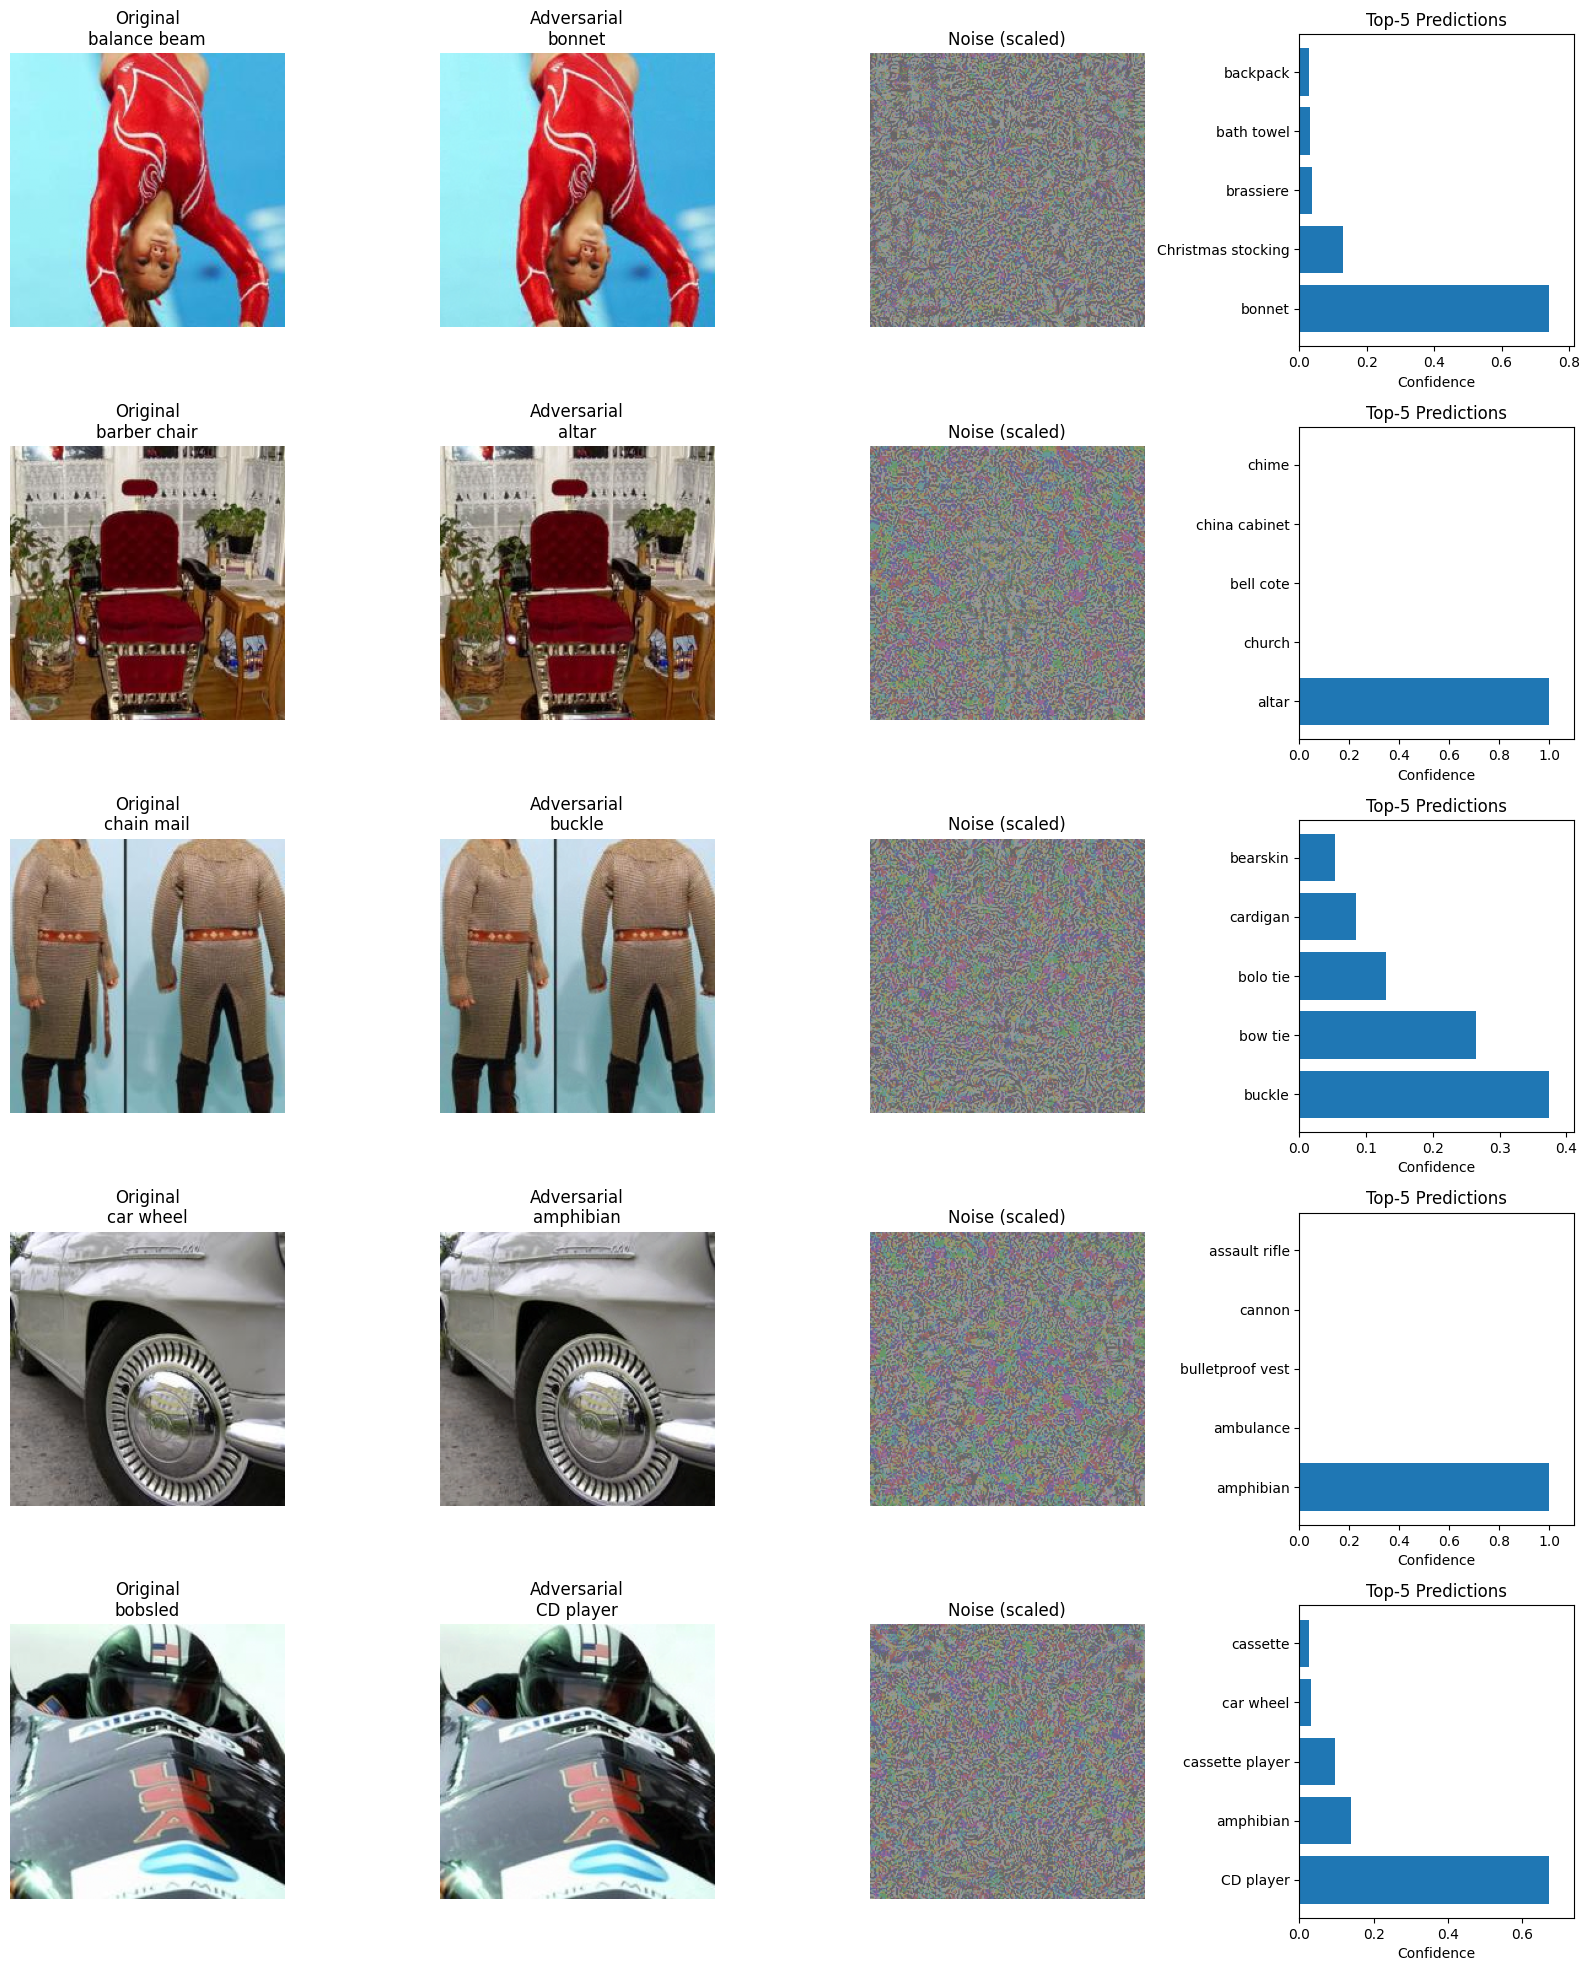

In [61]:
visualize_adversarial(
    dataset=dataset,
    adv_root=pgd_save_dir,
    model=pretrained_model,
    plain_transforms=plain_transforms,
    image_idx=image_idx,
    index_to_classname=index_to_classname,
    epsilon=0.02,
    num_examples=5
)

0.0039215686274510775
0.0039215686274510775
0.0039215686274510775
0.0039215686274510775
0.0039215686274510775
0.003921568627451022
0.0039215686274510775
0.0039215686274510775
0.003921568627451022
0.003921568627451022
0.0039215686274510775
0.003921568627451022
0.0039215686274510775
0.0039215686274510775
0.0039215686274510775
0.0039215686274510775
0.0039215686274510775
0.0039215686274510775
0.0039215686274510775
0.0039215686274510775
0.0039215686274510775
0.0039215686274510775
0.0039215686274510775
0.0039215686274510775
0.0039215686274510775
0.0039215686274510775
0.0039215686274510775
0.0039215686274510775
0.0039215686274510775
0.0039215686274510775
0.0039215686274510775
0.0039215686274510775
0.0039215686274510775
0.0039215686274510775
0.0039215686274510775
0.003921568627450994
0.0039215686274510775
0.0039215686274510775
0.0039215686274510775
0.0039215686274510775
0.003921568627450994
0.0039215686274510775
0.0039215686274510775
0.00392156862745098
0.003921568627451022
0.00392156862745107

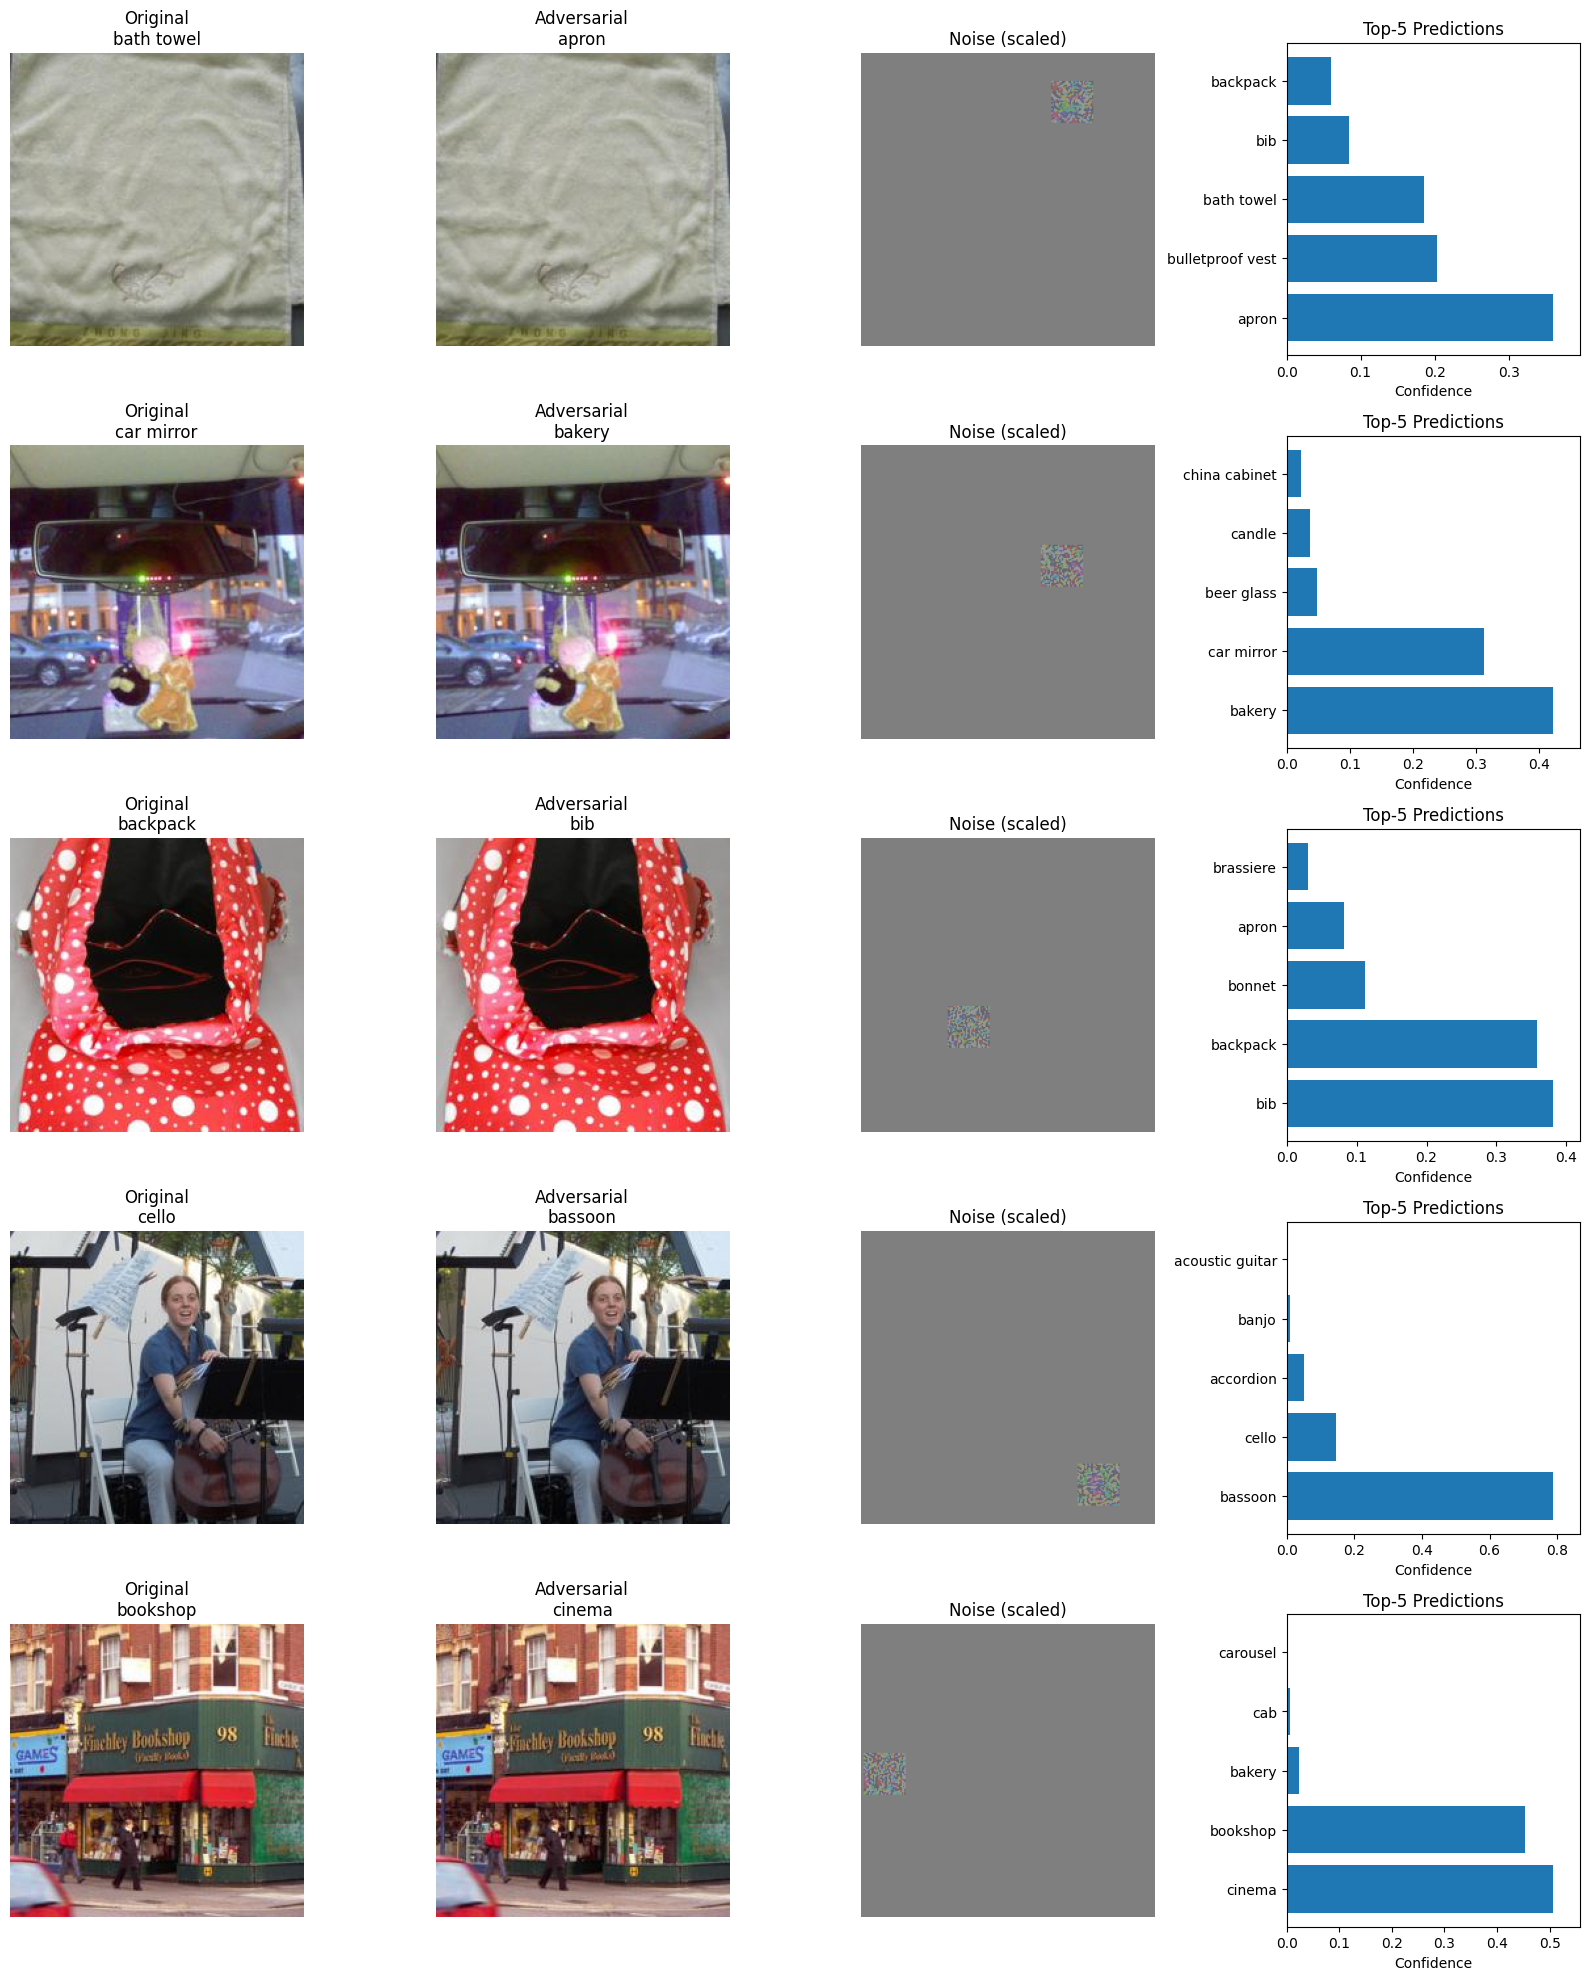

In [58]:
visualize_adversarial(
    dataset=dataset,
    adv_root=patch_save_dir,
    model=pretrained_model,
    plain_transforms=plain_transforms,
    image_idx=image_idx,
    index_to_classname=index_to_classname,
    epsilon=0.02,
    num_examples=5
)

0.01176470588235301
0.01176470588235301
0.01176470588235301
0.01176470588235301
0.01176470588235301
0.01176470588235301
0.01176470588235301
0.01176470588235301
0.01176470588235301
0.01176470588235301
0.01176470588235301
0.011764705882352955
0.01176470588235301
0.01176470588235301
0.01176470588235301
0.01176470588235301
0.01176470588235301
0.01176470588235301
0.01176470588235301
0.01176470588235301
0.01176470588235301
0.01176470588235301
0.01176470588235301
0.01176470588235301
0.011764705882352955
0.01176470588235301
0.01176470588235301
0.01176470588235301
0.01176470588235301
0.01176470588235301
0.01176470588235301
0.01176470588235301
0.01176470588235301
0.01176470588235301
0.01176470588235301
0.01176470588235301
0.01176470588235301
0.01176470588235301
0.01176470588235301
0.01176470588235301
0.01176470588235301
0.01176470588235301
0.01176470588235301
0.01176470588235301
0.01176470588235301
0.011764705882352955
0.01176470588235301
0.01176470588235301
0.01176470588235301
0.011764705882353

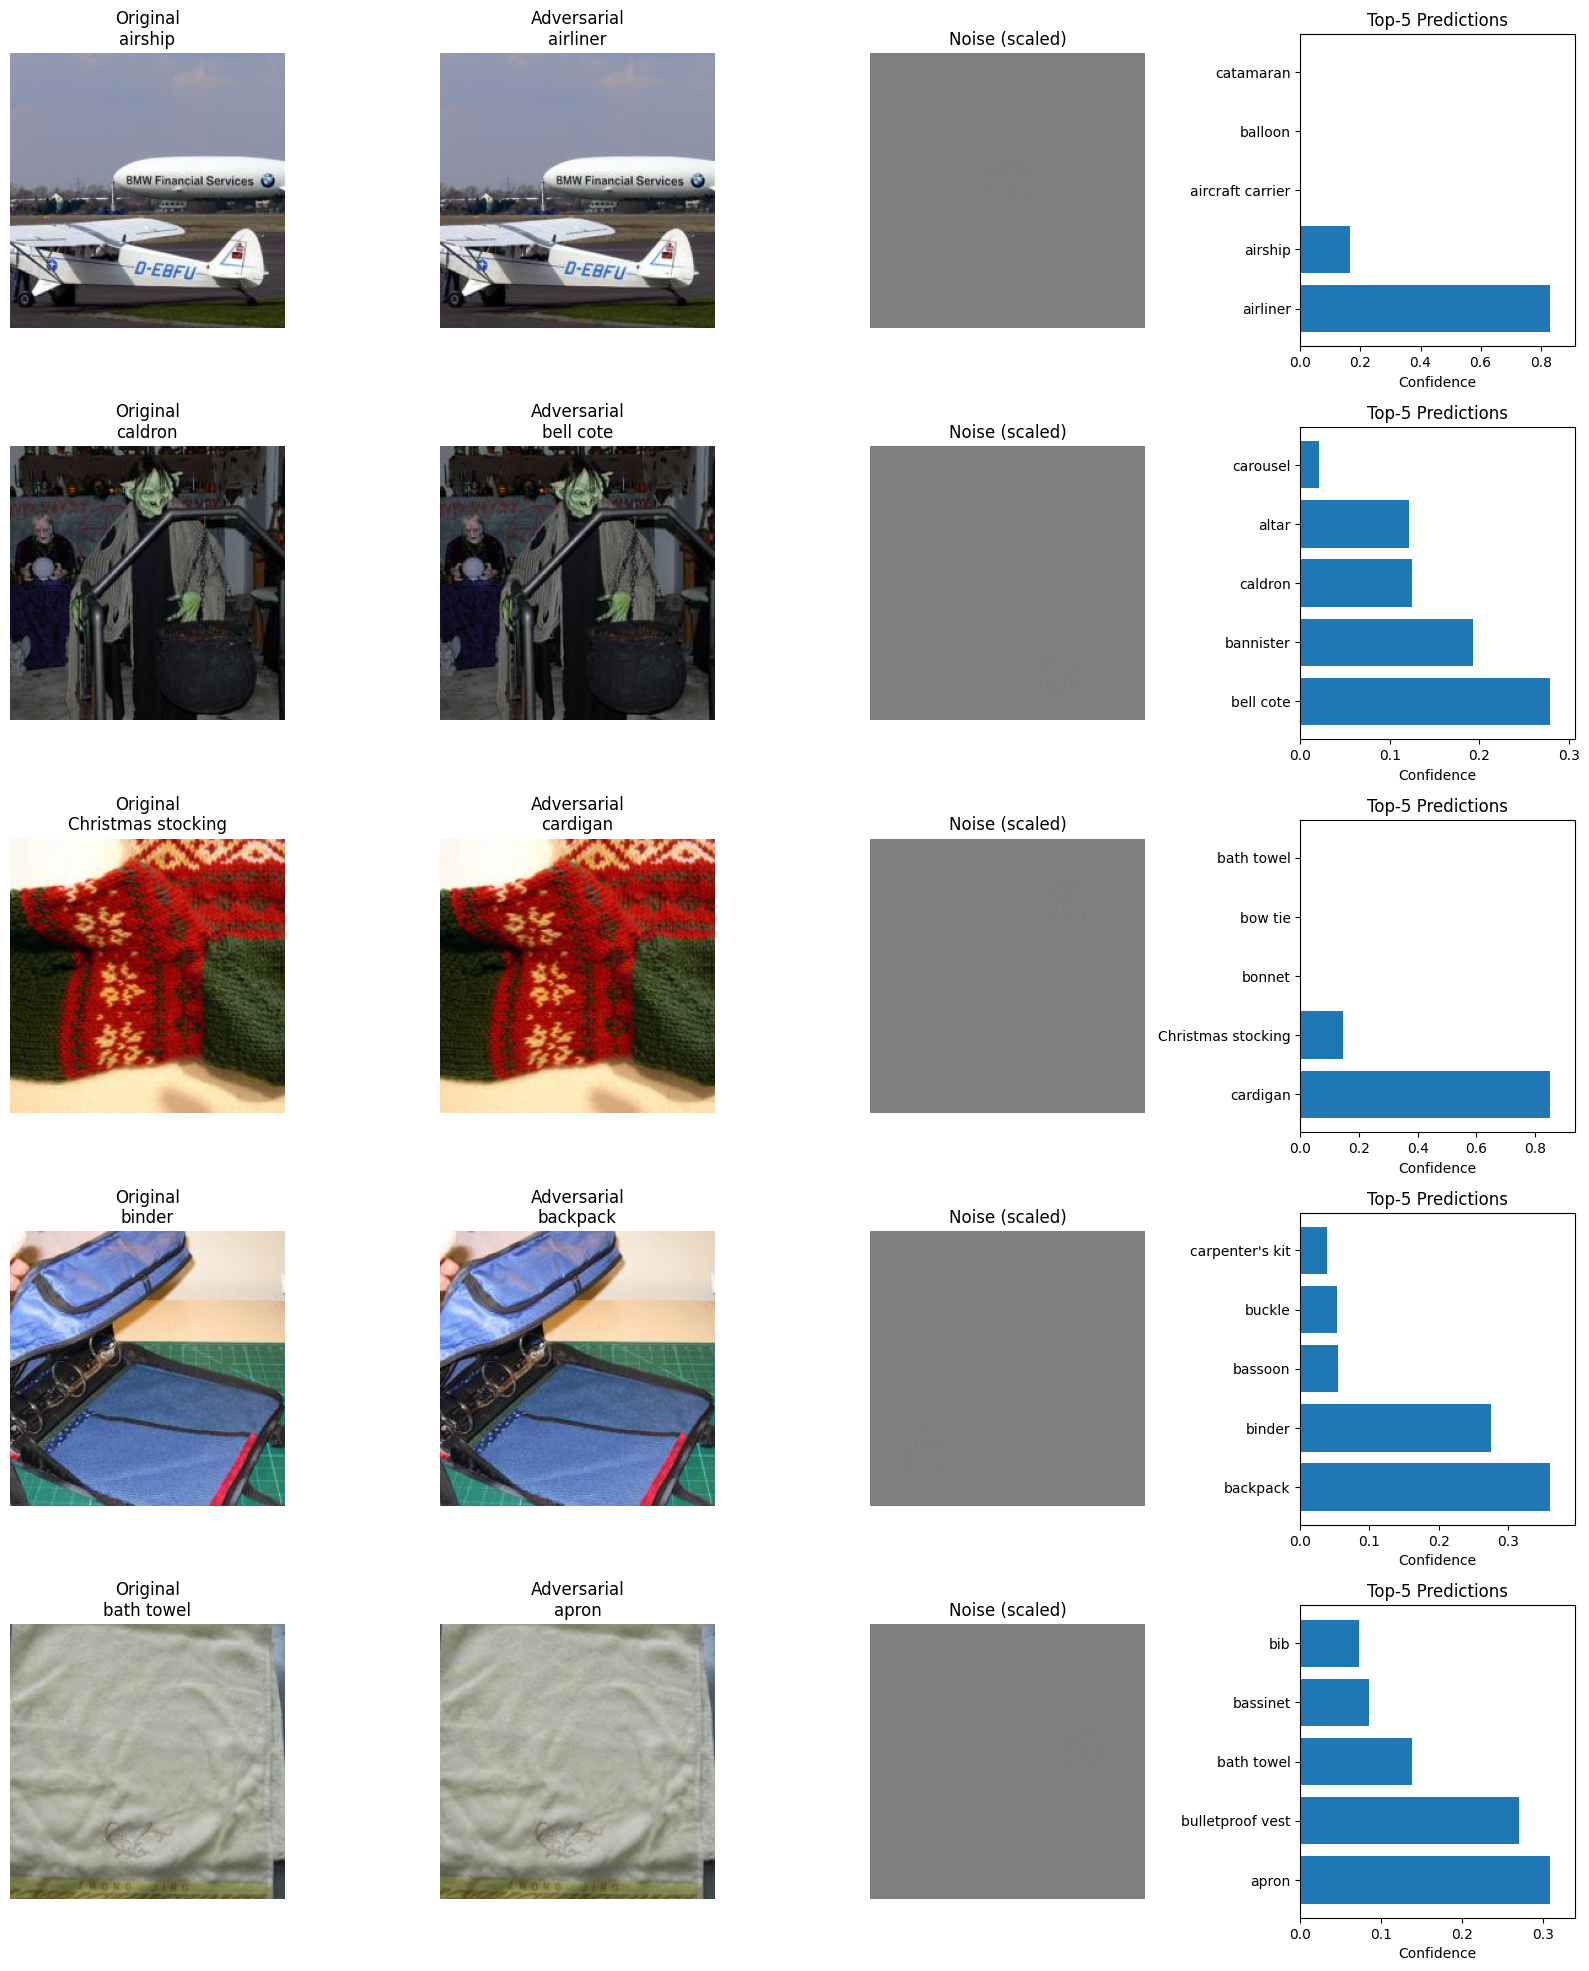

In [60]:
visualize_adversarial(
    dataset=dataset,
    adv_root=patch_save_dir,
    model=pretrained_model,
    plain_transforms=plain_transforms,
    image_idx=image_idx,
    index_to_classname=index_to_classname,
    epsilon=0.5,
    num_examples=5
)

0.02352941176470591
0.02352941176470591
0.02352941176470591
0.02352941176470591
0.02352941176470591
0.02352941176470591
0.02352941176470591
0.02352941176470591
0.02352941176470591
0.02352941176470591
0.02352941176470591
0.02352941176470591
0.02352941176470591
0.02352941176470591
0.02352941176470591
0.02352941176470591
0.02352941176470591
0.02352941176470591
0.02352941176470591
0.02352941176470591
0.02352941176470591
0.02352941176470591
0.02352941176470591
0.02352941176470591
0.02352941176470591
0.02352941176470591
0.02352941176470591
0.02352941176470591
0.02352941176470591
0.02352941176470591
0.02352941176470591
0.02352941176470591
0.02352941176470591
0.02352941176470591
0.02352941176470591
0.02352941176470591
0.02352941176470591
0.02352941176470591
0.02352941176470591
0.02352941176470591
0.02352941176470591
0.02352941176470591
0.02352941176470591
0.02352941176470591
0.02352941176470591
0.02352941176470591
0.02352941176470591
0.02352941176470591
0.02352941176470591
0.02352941176470591


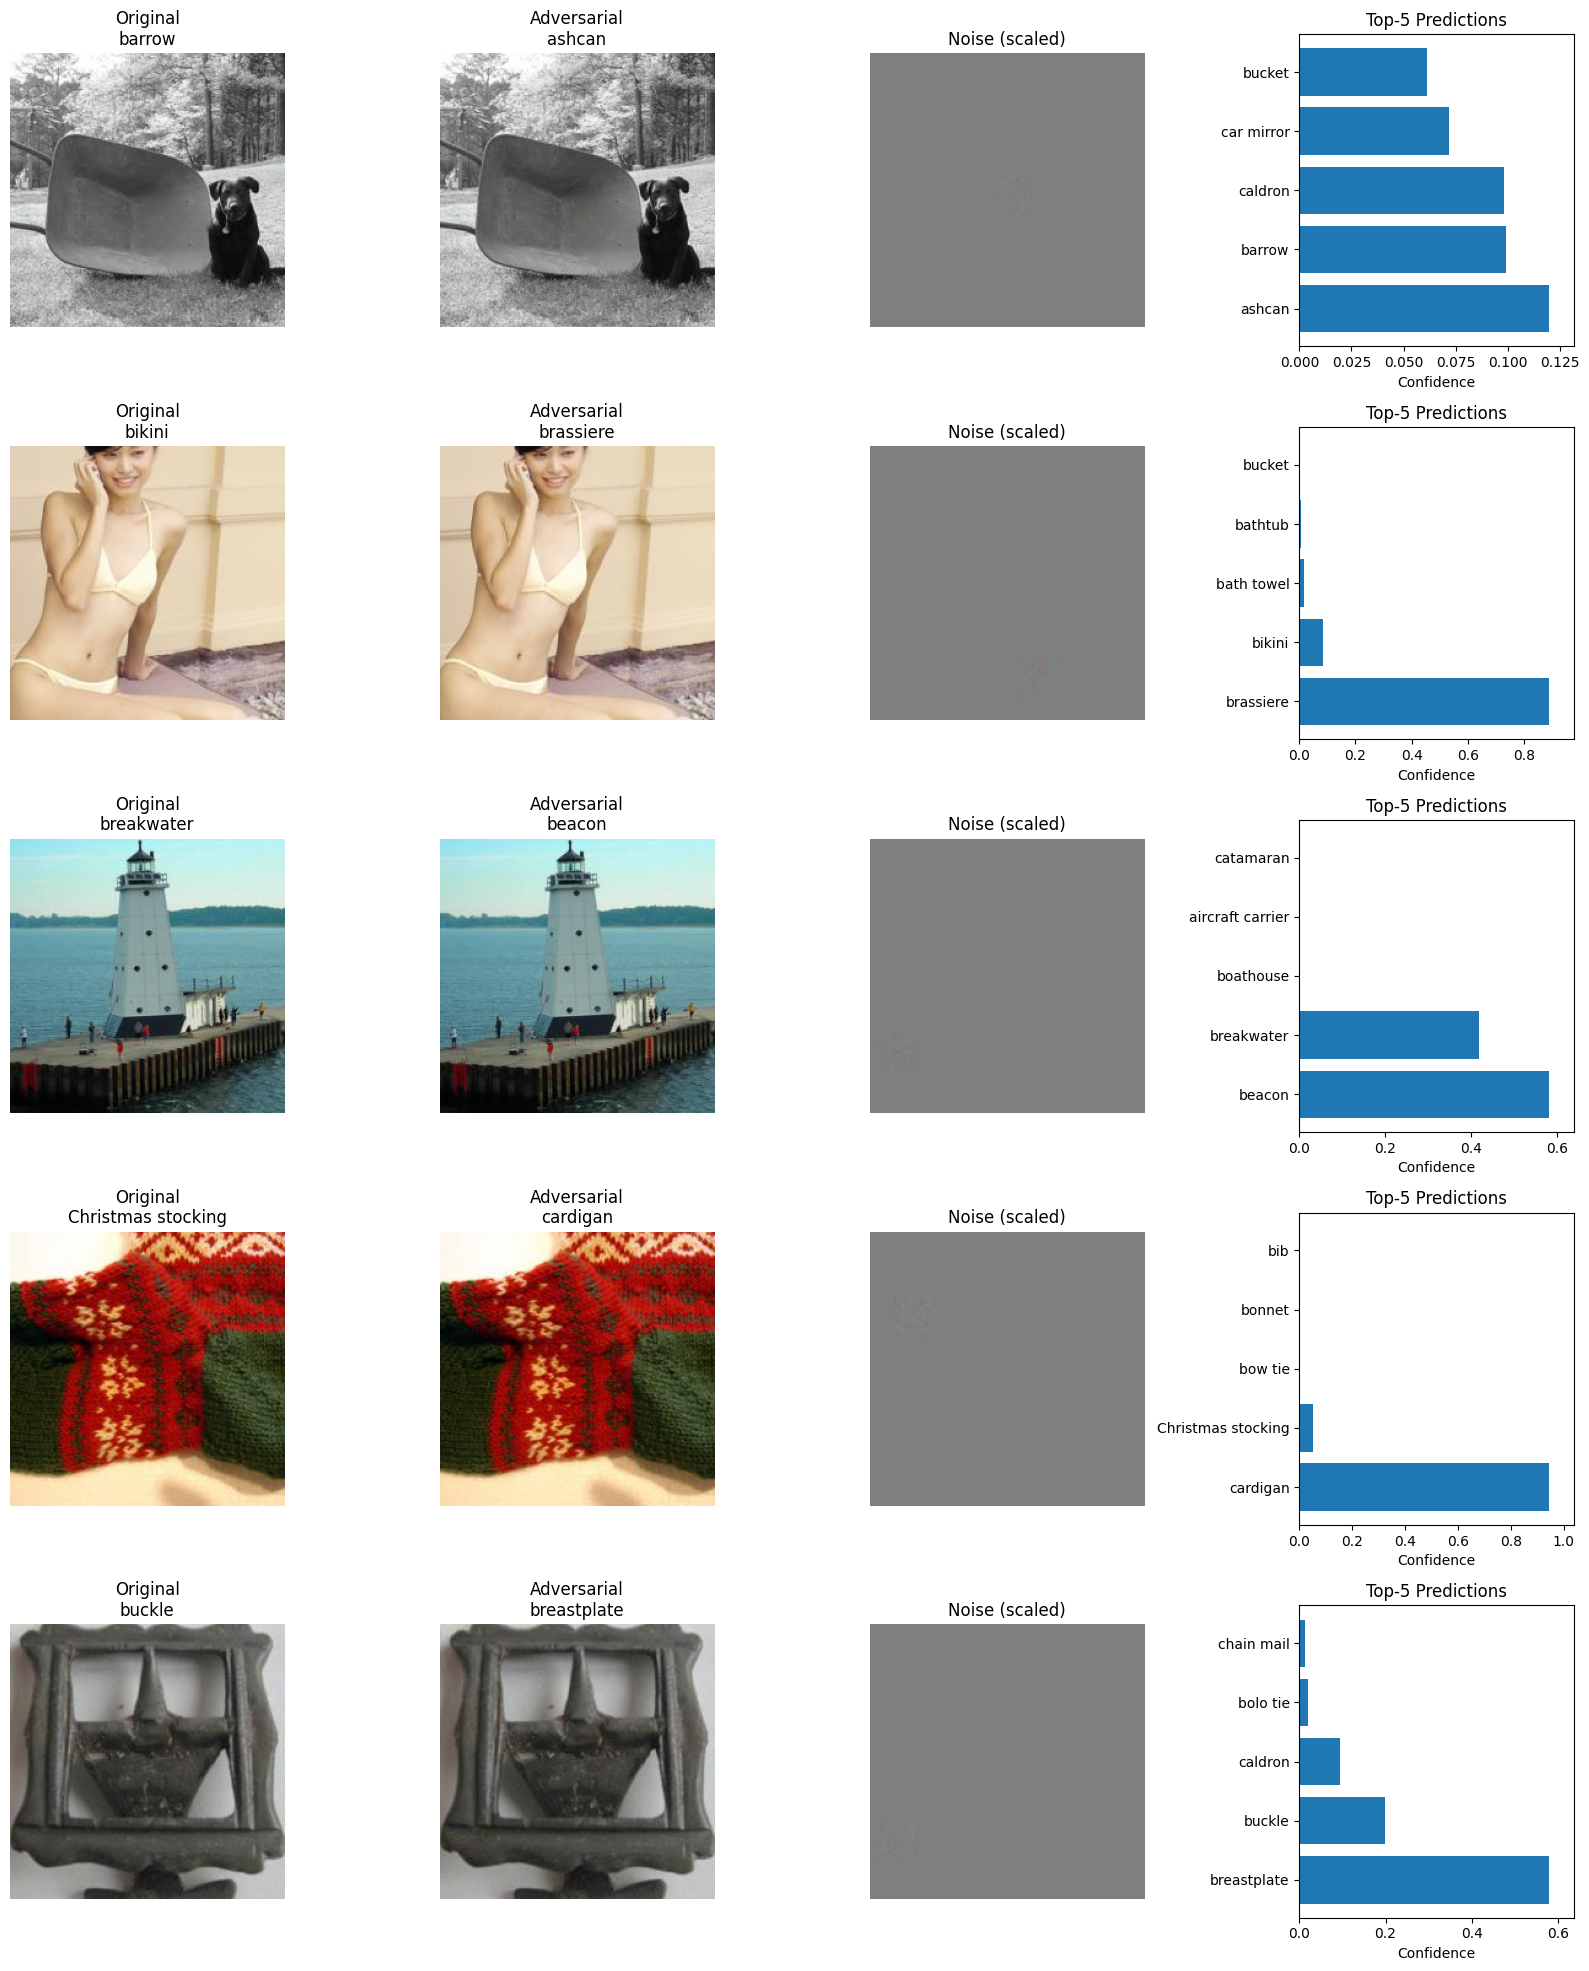

In [64]:
visualize_adversarial(
    dataset=dataset,
    adv_root=patch_save_dir,
    model=pretrained_model,
    plain_transforms=plain_transforms,
    image_idx=image_idx,
    index_to_classname=index_to_classname,
    epsilon=0.5,
    num_examples=5
)